In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from datasets import load_dataset, concatenate_datasets
from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm

/homes/53/fpinto/llm_hallucinations/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def error_type_map(example):
    # Any combination of error types is mapped into the same order.
    label_map = {
        "['extrinsic-NP']" : "['extrinsic-NP']",
        "['extrinsic-predicate']" : "['extrinsic-predicate']",
        "['intrinsic-NP']" : "['intrinsic-NP']",
        "['intrinsic-predicate']" : "['intrinsic-predicate']",
        'correct' : "['correct']",
        "['correct']" : "['correct']",

        "['extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-predicate']", 
        "['intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate']",
        "['extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP']" : "['intrinsic-predicate', 'extrinsic-NP']",
        "['extrinsic-NP', 'intrinsic-predicate']" : "['intrinsic-predicate', 'extrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'intrinsic-predicate']" : "['intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP']" : "['intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-NP', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['intrinsic-NP', 'extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-predicate', 'intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
        "['extrinsic-predicate', 'extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP']",
         
        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'extrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']",

        "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-NP', 'intrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-predicate', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",

        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate', 'intrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-predicate', 'intrinsic-NP', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-NP', 'intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        "['intrinsic-NP', 'extrinsic-predicate', 'intrinsic-predicate', 'extrinsic-NP']" : "['extrinsic-NP', 'extrinsic-predicate', 'intrinsic-NP', 'intrinsic-predicate']",
        }
    
    try:
        example['error_type'] = label_map[example['error_type']]
        return example
    
    except KeyError:
        return

In [3]:
dataset = load_dataset('Lislaam/AggreFact', split=['validation[:]', 'test[:]'])
dataset = concatenate_datasets([dataset[0], dataset[1]]) # Turn into one dataset to make new split

In [4]:
dataset = dataset.filter(lambda x: error_type_map(x) is not None)
dataset = dataset.map(error_type_map)

# Convert the dataset to a pandas DataFrame
df = dataset.to_pandas()
df['doc_length'] = df['doc'].apply(len)

Map: 100%|██████████| 4774/4774 [00:00<00:00, 9966.18 examples/s] 


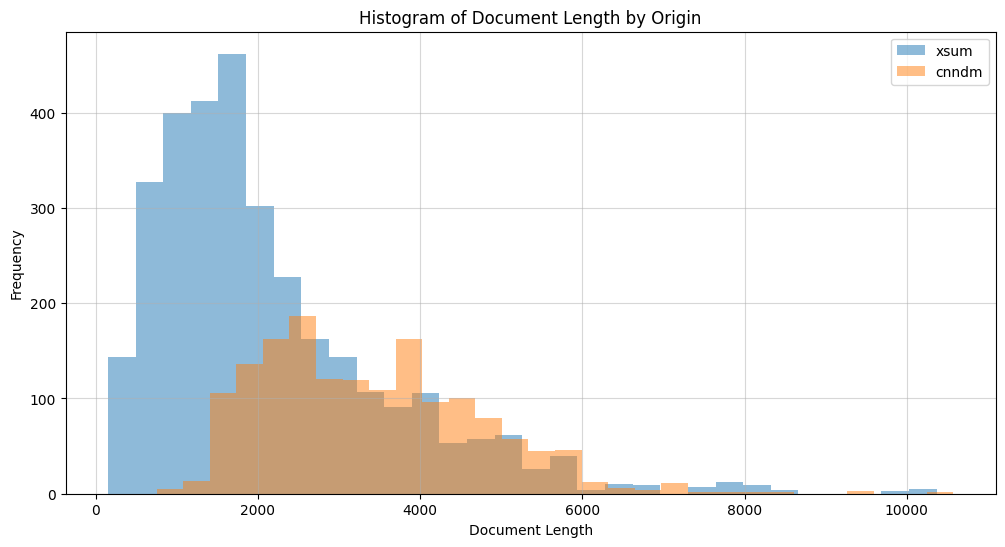

In [5]:
# Define the two origins you want to compare
origin_1 = 'xsum'  # Replace with the actual value for the first origin
origin_2 = 'cnndm'  # Replace with the actual value for the second origin

# Filter the DataFrame for the two origins
df_origin_1 = df[df['origin'] == origin_1]
df_origin_2 = df[df['origin'] == origin_2]

# Plot histograms of document length for each origin
plt.figure(figsize=(12, 6))
plt.hist(df_origin_1['doc_length'], bins=30, alpha=0.5, label=origin_1)
plt.hist(df_origin_2['doc_length'], bins=30, alpha=0.5, label=origin_2)

# Add labels and title
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.title('Histogram of Document Length by Origin')
plt.legend(loc='upper right')
plt.grid(alpha=0.5)

# Show the plot
plt.show()

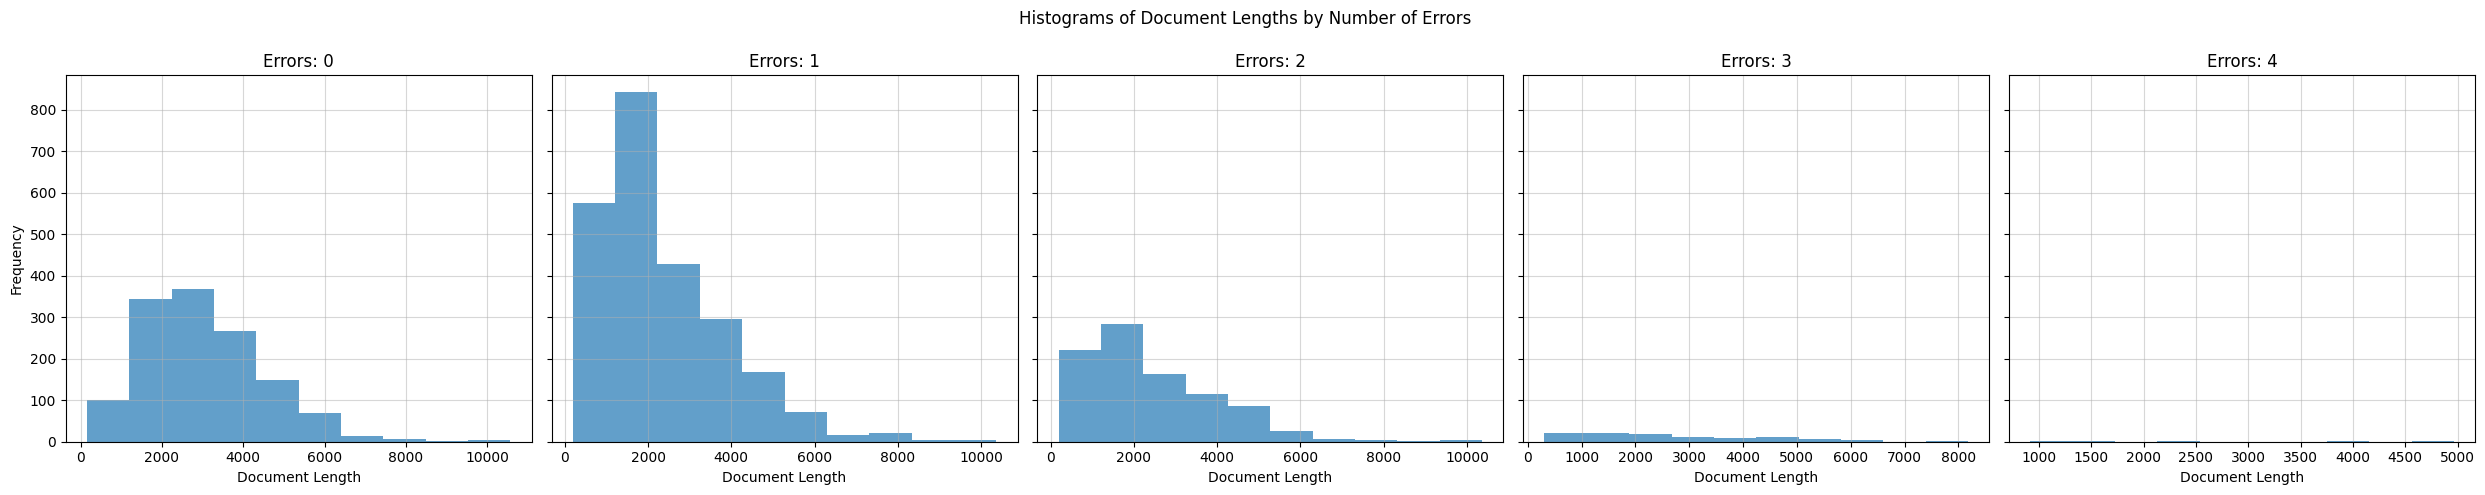

In [6]:
# Get num of errors vs length of doc

df['error_type_list'] = df['error_type'].apply(lambda x: ast.literal_eval(x))
df['num_errors'] = df['error_type_list'].apply(lambda x: len(x) if x != ['correct'] else 0)

# Define the range of unique error counts you want to plot
unique_error_counts = range(5)  # Assuming 'num_errors' ranges from 0 to 4

# Create subplots with 1 row and 5 columns (one for each error count)
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)  # Share y-axis for better comparison

# Loop over each unique error count and corresponding subplot axis
for num_error, ax in zip(unique_error_counts, axes):
    # Filter the dataframe to include only rows with the current number of errors
    subset = df[df['num_errors'] == num_error]
    
    # Plot the histogram for the current subset of documents
    ax.hist(subset['doc_length'], bins=10, alpha=0.7)
    
    # Set title and labels for each subplot
    ax.set_title(f'Errors: {num_error}')
    ax.set_xlabel('Document Length')
    ax.grid(alpha=0.5)
    if num_error == 0:
        ax.set_ylabel('Frequency')  # Only set y-axis label on the first subplot

# Set a common title for the entire figure
fig.suptitle('Histograms of Document Lengths by Number of Errors')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make room for the main title

# Show the plot
plt.show()